In [54]:
import numpy as np
import torch
from torch import nn
import os
import glob
from torch.utils.data import DataLoader, random_split

In [55]:
from utility import predict_fuc, load_best_model
from linear_MLP import MLP

In [57]:
batch_size = 1
model = MLP().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# model, optimizer, best_val_loss, target_min, target_max = load_best_model(
#     model, optimizer,
#     '/kaggle/input/noisereduction/pytorch/default/1/best_model_NR_v2.0.pth')
model, optimizer, best_val_loss, target_min, target_max = load_best_model(
    model, optimizer, '/kaggle/best_model_LR_v1.0.pth')

Best model loaded.


In [58]:
from linear_process import preprocess_pro
from utility import cal_flux, predict_spectra

In [36]:
# predictions_spectra_test = preprocess_pro('test')

In [59]:
import pickle
with open('train_preprocessed.pkl', 'rb') as file:
    full_predictions_spectra_test = pickle.load(file)

In [60]:
full_predictions_spectra_test.shape

(673, 187, 283)

In [63]:
np.random.seed(42)
indices = np.random.choice(full_predictions_spectra_test.shape[0],
                           320,
                           replace=False)

In [65]:
mask = np.ones(full_predictions_spectra_test.shape[0], dtype=bool)
mask[indices] = False
predictions_spectra_test = full_predictions_spectra_test[mask]

In [66]:
predictions_spectra_test.shape

(353, 187, 283)

In [67]:
wave_alpha_test = np.array([
    cal_flux(predictions_spectra_test[i])
    for i in range(len(predictions_spectra_test))
])
whitelight_s_test = np.array([
    predict_spectra(predictions_spectra_test[i])
    for i in range(len(predictions_spectra_test))
])  # 预测每个星球的白光缩放比例S
b = 0.007255
a = 0.000375
whitelight_s_test_normalized = (whitelight_s_test - a) / (b - a)
whitelight_s_test_reshaped = whitelight_s_test_normalized[:, np.newaxis]
data_test_reshaped = np.concatenate(
    [np.stack(wave_alpha_test),
     np.stack(whitelight_s_test_reshaped)],
    axis=1  # 按第 2 维度（axis=1）进行合并，以便后续一起处理
)
data_test_reshaped = torch.tensor(data_test_reshaped).float()

In [68]:
all_predictions = predict_fuc(model, data_test_reshaped, batch_size=1)
all_predictions = all_predictions * (target_max - target_min) + target_min
all_predictions = all_predictions.numpy()

In [69]:
all_predictions.shape

(353, 283)

In [70]:
from utility import postprocessing, competition_score
import pandas as pd

wavelengths = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/wavelengths.csv')
test_adc_info = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
    index_col='planet_id')
train_labels = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
    index_col='planet_id')

In [73]:
test_adc_info[mask].index

Int64Index([  14485303,   24135240,   25070640,   26372015,   50637799,
              62282335,   75219649,   79009616,   90833891,  100468857,
            ...
            4141729806, 4150857627, 4154084890, 4167675411, 4176562407,
            4197469272, 4199801857, 4247255382, 4247918843, 4266129805],
           dtype='int64', name='planet_id', length=353)

In [74]:
all_predictions.shape

(353, 283)

In [79]:
from sklearn.metrics import r2_score, mean_squared_error

auxiliary_folder = 'input/ariel-data-challenge-2024/'
train_solution = np.loadtxt(
    '/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
    delimiter=',',
    skiprows=1)

targets = train_solution[:, 1:]

In [80]:
print(f"# R2 score: {r2_score(targets[mask], all_predictions):.3f}")
sigma_pred = mean_squared_error(targets[mask], all_predictions, squared=False)
print(f"# Root mean squared error: {sigma_pred:.6f}")

# R2 score: 0.041
# Root mean squared error: 0.001647


In [85]:
sub_df = postprocessing(all_predictions,
                        wavelengths,
                        test_adc_info[mask].index,
                        sigma_pred=np.tile(
                            np.where(test_adc_info[mask][['star']] <= 1,
                                     0.001647, 0.001), (1, 283)))

In [86]:
gll_score = competition_score(train_labels[mask].copy().reset_index(),
                              sub_df.copy().reset_index(),
                              naive_mean=train_labels[mask].values.mean(),
                              naive_sigma=train_labels[mask].values.std(),
                              sigma_true=0.00001)
print(f"# Estimated competition score: {gll_score:.3f}")

# Estimated competition score: 0.004


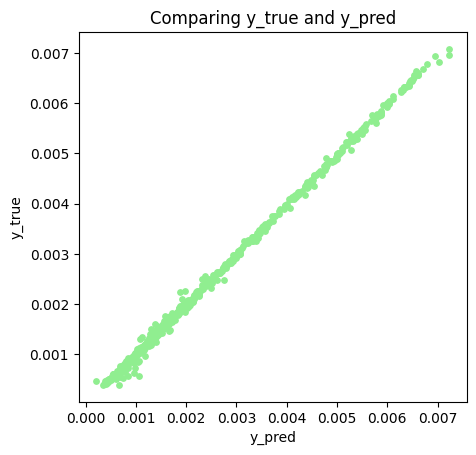

In [47]:
import matplotlib.pyplot as plt

col = 1
plt.scatter(all_predictions[:, col], targets[:, col], s=15, c='lightgreen')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred')
plt.show()

In [48]:
import numpy as np
from scipy import stats

col = 3
# 假设 predict_targets 和 targets 是 numpy 数组
errors = np.abs(all_predictions[:, col] - targets[:, col])
z_scores = np.abs(stats.zscore(errors))

# 设置 Z-score 阈值，通常为 3
threshold = 3
outliers = np.where(z_scores > threshold)

# 打印异常值索引
print("Outlier lens:", len(outliers[0]))
print("Outliers:", outliers)

Outlier lens: 19
Outliers: (array([ 23,  24,  31, 153, 177, 192, 234, 258, 267, 352, 378, 382, 443,
       461, 498, 545, 547, 600, 649], dtype=int64),)


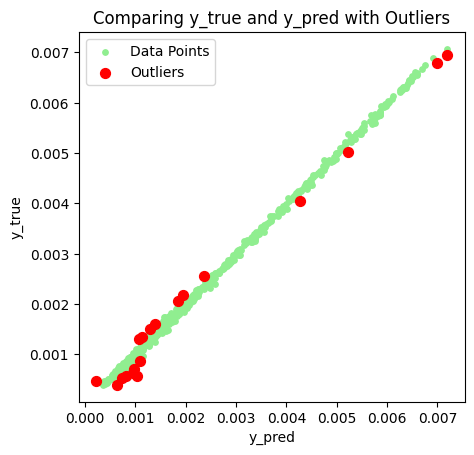

In [49]:
import matplotlib.pyplot as plt

plt.scatter(all_predictions[:, col],
            targets[:, col],
            s=15,
            c='lightgreen',
            label='Data Points')
plt.scatter(all_predictions[outliers[0], col],
            targets[outliers[0], col],
            s=50,
            c='red',
            label='Outliers')
plt.gca().set_aspect('equal')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title('Comparing y_true and y_pred with Outliers')
plt.legend()
plt.show()

In [50]:
import numpy as np
from scipy import stats
from collections import Counter, defaultdict

# 假设 predict_targets 和 targets 是 numpy 数组
num_cols = all_predictions.shape[1]
threshold = 3
outlier_counts = Counter()
normal_columns = defaultdict(list)

for col in range(num_cols):
    errors = np.abs(all_predictions[:, col] - targets[:, col])
    z_scores = np.abs(stats.zscore(errors))
    outliers = np.where(z_scores > threshold)[0]
    normals = np.where(z_scores <= threshold)[0]

    # 统计每个异常点的频次
    outlier_counts.update(outliers)

    # 记录每个数据点在哪些列中是正常的
    for normal in normals:
        normal_columns[normal].append(col)

# 按频次排序
sorted_outliers = outlier_counts.most_common()

# 打印每个异常点的频次及其正常的列
for outlier, count in sorted_outliers:
    normal_cols = normal_columns[outlier]
    print(
        f"Data point {outlier} is an outlier in {count} columns and normal in columns: {normal_cols}"
    )

Data point 31 is an outlier in 283 columns and normal in columns: []
Data point 267 is an outlier in 283 columns and normal in columns: []
Data point 498 is an outlier in 283 columns and normal in columns: []
Data point 649 is an outlier in 283 columns and normal in columns: []
Data point 382 is an outlier in 277 columns and normal in columns: [136, 181, 182, 183, 184, 185]
Data point 600 is an outlier in 270 columns and normal in columns: [0, 5, 134, 135, 136, 137, 139, 140, 180, 181, 182, 184, 185]
Data point 378 is an outlier in 241 columns and normal in columns: [130, 131, 134, 135, 136, 138, 143, 144, 146, 148, 149, 152, 153, 155, 156, 157, 158, 159, 163, 164, 165, 171, 175, 176, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 198, 210, 222, 252]
Data point 24 is an outlier in 239 columns and normal in columns: [0, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 48, 50, 90, 91, 92, 93, 94, 95, 272, 274, 275,